In [1]:
from tensorflow import keras
import tensorflow as tf
import gc

In [2]:
from CustomLayers import *
from GS_composer import *
from Functions import *
from ClassModel import *

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [3]:
#user_profile = "E:/learning resource/"
#user_profile = "C:/Users/uqcche32/"
user_profile = "D:/"

Model_series = "MultiLevel/MultiLevel_Attention_1Head_pcaIndex"
Model_path = user_profile+"OneDrive - The University of Queensland/PhD/HPC_Results/Sugarcane_disease/ML/" + Model_series
Model_path = "F:/PhD_Notebook/Code/ML_composer/"
Model_path = "H:/ML_archive/test_model"
#Model_path = "E:/learning resource/OneDrive - The University of Queensland/PhD/HPC_Results/Sugarcane_disease/ML/"

In [4]:
from keras import backend as K

In [5]:
print(tf.__version__)

2.9.1


In [6]:
model_folder = "smut_MultiLevelAttention_1"

#model_folder = "test_model"
full_path = Model_path + "/" + model_folder
print(full_path)
model = keras.models.load_model(full_path,custom_objects={"MultiLevel_BlockAttention": MultiLevel_BlockAttention,
                                                         "OrdinalOutputLayer":OrdinalOutputLayer,
                                                         "GroupedLocallyConnectedLayer":GroupedLocallyConnectedLayer})

H:/ML_archive/test_model/smut_MultiLevelAttention_1
(None, 7, 8)
from buiild


In [7]:
model.summary()
#model = keras.Model(inputs=input1, outputs=QV_output)
model.compile(optimizer="RMSprop", loss="mean_squared_error")

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer_1 (InputLayer)     [(None, 100, 1)]     0           []                               
                                                                                                  
 zero_padding1d (ZeroPadding1D)  (None, 105, 1)      0           ['input_layer_1[0][0]']          
                                                                                                  
 locally_connected1d (LocallyCo  (None, 7, 8)        840         ['zero_padding1d[0][0]']         
 nnected1D)                                                                                       
                                                                                                  
 dense (Dense)                  (None, 7, 8)         72          ['locally_connected1d[0][0]']

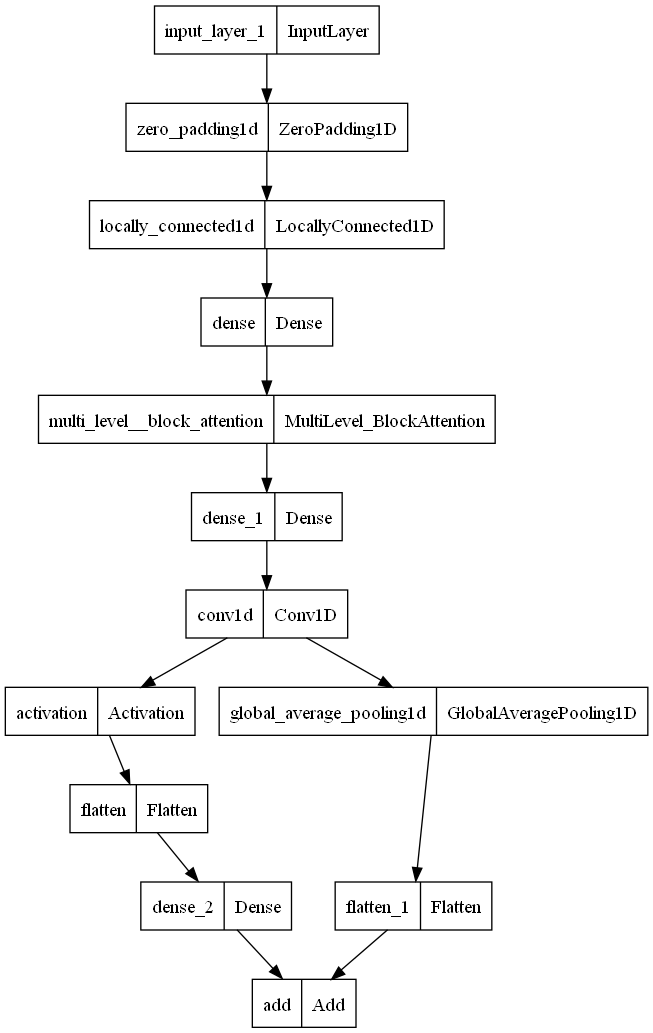

In [8]:

keras.utils.plot_model(model,to_file=full_path + "model.png")

A test variable of SNP array based on the freq of alleles.

In [18]:

#data = np.ones((1, 26086, 1))
test_filename = user_profile+"OneDrive - The University of Queensland/PhD/data/sugarcane_disease/sugarcane_disease.freqV1.ped"
data = pd.read_csv(test_filename,header=None,sep="\t").iloc[:,6:]
data=np.expand_dims(data,axis=-1)
print(data.shape)

(1, 26086, 1)


Model predict via test freq data

In [19]:
model.predict(data)

1/1 [==============================] - 2s 2s/step


array([[5.1038203]], dtype=float32)

Extract layer weights and outputs from the model

In [ ]:
intermediate_layer_model = tf.keras.Model(inputs=model.input,
                                         outputs=model.get_layer('dense_2').output)

In [ ]:
intermediate_output = intermediate_layer_model.predict(data)

In [ ]:
attention = intermediate_output[0]
attention = K.expand_dims(attention,axis=1)
print(attention.shape)

In [ ]:
LNN_weight = model.layers[2].get_weights()

In [ ]:
LNN_weight[0].shape

In [ ]:
LNN_weight[0].shape

In [ ]:
SNP_attention = tf.multiply(attention,LNN_weight[0])

In [ ]:
SNP_attention = tf.reshape(SNP_attention,(26080,1,32))

In [ ]:
mean_SNP_attention = SNP_attention
#mean_SNP_attention = tf.reduce_mean(SNP_attention,axis=2)
mean_SNP_attention.shape
#mean_SNP_attention =np.array(tf.reshape(mean_SNP_attention,(26080,))) #np.array(tf.reshape(mean_SNP_attention,(26080*32,)))
mean_SNP_attention =np.array(tf.reshape(mean_SNP_attention,(26080,32)))

In [ ]:
import matplotlib.pyplot as plt
import math

In [ ]:
np.mean(mean_SNP_attention)

In [ ]:
print(mean_SNP_attention.shape)
#plt.scatter(x=np.tile(np.arange(0,26080),1),y=abs(mean_SNP_attention))
plt.scatter(x=np.tile(np.arange(0,26080),32),y=mean_SNP_attention)

In [ ]:
mean_SNP_attention.shape

In [ ]:
def export_attention_score_by_trait(filename,trait,val):
    model = keras.models.load_model(filename,custom_objects={"MultiHead_QKV_BlockAttention": MultiHead_QKV_BlockAttention,
                                                         "SNPBlockLayer":SNPBlockLayer})
    model.summary()
    #model = keras.Model(inputs=input1, outputs=QV_output)
    model.compile(optimizer="RMSprop", loss="mean_squared_error")
    test_filename = user_profile+"OneDrive - The University of Queensland/PhD/data/sugarcane_disease/sugarcane_disease.freqV1.ped"
    data = pd.read_csv(test_filename,header=None,sep="\t").iloc[:,6:]
    data=np.expand_dims(data,axis=-1)
    print(data.shape)
    intermediate_layer_model = tf.keras.Model(inputs=model.input,
                                         outputs=model.get_layer('add_3').output)
    intermediate_output = intermediate_layer_model.predict(data)
    attention = intermediate_output[0]
    attention = K.expand_dims(attention,axis=1)
    print(attention.shape)
    
    LNN_weight = model.layers[2].get_weights()
    SNP_attention = tf.multiply(attention,LNN_weight[0])
    SNP_attention = np.array(tf.reshape(SNP_attention,(32,26080)))
    SNP_attention = pd.DataFrame(SNP_attention,columns=list(range(1,SNP_attention.shape[1]+1)))
    SNP_attention.shape
    SNP_attention.insert(0,'Channel',range(1,33))
    SNP_attention.insert(0,'Val',val)
    SNP_attention.insert(0,"Trait",trait)
    
    SNP_attention = SNP_attention.values.tolist()
    #mean_SNP_attention = [trait,val]+list(np.array(tf.reshape(mean_SNP_attention,(26080,))))
    #mean_SNP_attention = pd.DataFrame([trait,val]+list(mean_SNP_attention),columns=[trait,val]+list(range(1,length(mean_SNP_attention))))
    model = None
    keras.backend.clear_session()
    gc.collect()
    
    return SNP_attention
    
    

In [ ]:
def export_LD_attention_score_by_trait(filename,trait,val):
    model = keras.models.load_model(filename,custom_objects={"MultiHead_QKV_BlockAttention": MultiHead_QKV_BlockAttention,
                                                         "SNPBlockLayer":SNPBlockLayer})
    model.summary()
    #model = keras.Model(inputs=input1, outputs=QV_output)
    model.compile(optimizer="RMSprop", loss="mean_squared_error")
    test_filename = user_profile+"OneDrive - The University of Queensland/PhD/data/sugarcane_disease/sugarcane_disease.freqV1.ped"
    data = pd.read_csv(test_filename,header=None,sep="\t").iloc[:,6:]
    data=np.expand_dims(data,axis=-1)
    print(data.shape)
    intermediate_layer_model = tf.keras.Model(inputs=model.input,
                                         outputs=model.get_layer('multi_head_qkv__block_attention').output)
    intermediate_output = intermediate_layer_model.predict(data)
    attention = intermediate_output[0]
    attention = K.expand_dims(attention,axis=1)
    print(attention.shape)
    
    #LNN_weight = model.layers[2].get_weights()
    #SNP_attention = tf.multiply(attention,LNN_weight[0])
    LD_attention = np.array(tf.reshape(attention,(32,2608)))
    LD_attention = pd.DataFrame(LD_attention,columns=list(range(1,LD_attention.shape[1]+1)))

    LD_attention.insert(0,'Channel',range(1,33))
    LD_attention.insert(0,'Val',val)
    LD_attention.insert(0,"Trait",trait)
    
    LD_attention = LD_attention.values.tolist()
    #mean_SNP_attention = [trait,val]+list(np.array(tf.reshape(mean_SNP_attention,(26080,))))
    #mean_SNP_attention = pd.DataFrame([trait,val]+list(mean_SNP_attention),columns=[trait,val]+list(range(1,length(mean_SNP_attention))))
    model = None
    keras.backend.clear_session()
    gc.collect()
    
    return LD_attention

In [ ]:
Model_path = user_profile+"OneDrive - The University of Queensland/PhD/HPC_Results/Sugarcane_disease/ML/1Head_RealForm32_32LocalB/"
records = []
for trait in ["smut","pachy"]:
    for val in range(1,6):
        filename = Model_path + trait + "_MultiHeadAttentionLNN_"+str(val)
        record = export_attention_score_by_trait(filename,trait,val)
        records.append(record)


In [ ]:
recordss = []
for i in records:
    for j in i:
        recordss.append(j)
records_df = pd.DataFrame(recordss,columns=["Trait","Val","Channel"]+list(range(1,26081)))
output_path = Model_path + "Attention_block_Normscore.csv"
records_df.to_csv(output_path,sep="\t",index=False)

In [ ]:
len(recordss[0])

In [ ]:
records.insert(0,"Val", #columns.values[0:2] = ["Trait","Val"]
output_path = Model_path + "Attention_score.csv"
records.to_csv(output_path,sep="\t",index=False)

In [ ]:
records_df.describe()

In [ ]:
intermediate_layer_model = tf.keras.Model(inputs=model.input,
                                         outputs=model.get_layer('multi_head_qkv__block_attention').output)
intermediate_output = intermediate_layer_model.predict(data)
attention = intermediate_output[0]
attention = K.expand_dims(attention,axis=1)
print(attention.shape)
pd.DataFrame(np.array(tf.reshape(attention,(32,2608)))).describe()

In [ ]:
keras.backend.clear_session()
gc.collect()